In [4]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import torch, copy
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
import  matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from module.Model import TwoLayerNet
from module.Weight_tune import *
from module.Reorg import *
from module.Cram import *
from module.Init import *
from module.LTS import *
from utils import *
from module.Data import *
import datetime





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# New Learning mechanism

### Virtual env


- fingpu, on GPU

### Data

In [10]:
data = pd.read_csv("Copper_forecasting_data.csv")
X_train, X_test, y_train, y_test = preprocess(data)
input_dim = X_train.shape[1]
test_loader = loader(X_test, y_test)
# check data device
X_train.device, y_train.device


(device(type='cuda', index=0), device(type='cuda', index=0))

### Config

In [11]:
# learning goal: max eps < learning goal
dtype = torch.float64
learning_goal = torch.exp(torch.tensor(1)).to(dtype = dtype).to(device)
lr_rate = .001
lr_bound = 1e-5
criterion = nn.MSELoss()
epochs = 50
"""
# Note
1. hidden dim should check the previous model. dynamically change
2. For lr_rate, lr bound, lr goal (eps bound) are all the same fro eahc module
"""

# config for weight tune
config_wt = {
    "epochs": epochs,
    "criterion": criterion,        # loss function
    "lr_rate": lr_rate,            # learning rate 
    "lr_bound": lr_bound,          # lower bound of learning rate 
    "lr_goal": learning_goal,      # if regular eps < eps_reg: accept the model
}

# config for cram
config_cram = {
    "lr_goal": learning_goal, 
    "s": 0.001,                     # a small num in cram
}

# config for reorganise
config_reorg  = {
    "epochs": epochs,
    "criterion": criterion,        # loss function
    "lr_rate": lr_rate,            # learning rate 
    "lr_bound": lr_bound,          # lower bound of learning rate 
    "lr_goal": learning_goal,      # if regular eps < eps_reg: accept the model
    "print_reg": False,            # print detail, eg. loss for each epoch, or not
    "print_w_tune": False,         # print detail, eg. loss for each epoch, or not
    "validate_run": False,         # validate the model, or not
}
# NOTE 
# 1. for leaning goals, if first using weightune and no LTS or otherthings, 
# 13 for getting acceptable wt | 10 not acceptable


### Full Path

- L11 p9, third learning mechanism\
`Check: should y add .reshape(-1, 1)? since some warning shows when testing the final model`\
`Check validate section`    
`Check not using test data to train`

In [12]:
#################################################################
# Full step for the learning algorithm mechanism
# NOTE
# 1. model right before reorg always need to be acceptable model
# 2. model after cram and reorg always need to be acceptable 
# 3. check for the above every time after cram and reorg
# 4. the randomness: in cram find r
#################################################################
from module.Cram import *
from module.Reorg import *
from module.Weight_tune import *

# 0. Open log file
file_create_time = str(datetime.datetime.now().date())
out_file = open(f"log/{file_create_time}" + '.txt', 'a')
write(out_file, f"#######################################")
write(out_file, str(datetime.datetime.now()))
write(out_file, f"#######################################")

# 1. initializing_1_ReLU_LR | L11 p2

model = init_model(X_train, y_train)
n = 0
n_not_fit = 5
model_history = {}


while n < len(X_train):
    write(out_file, f"\n\n\n")
    write(out_file, f"=======================")
    write(out_file, f"//////////// Start New lts")
    models_within_iter = {}
    # 2. obtaining_LTS / selecting_LTS
    train_loader, indices, X_train_lts, y_train_lts, n = \
        lts(model, X_train, y_train, learning_goal, n_not_fit, out_file)

    # 3. check learning goal
    acceptable, eps_sqaure, y_pred = acceptable_eps_ypred(train_loader, model, learning_goal)
    models_within_iter["begin"] = model
    if acceptable:
        continue

    else:
        torch.save(model, "unacceptable/selecting.pth")

        # store model in acceptable/wt.pth if acceptable
        # store model in unacceptable/wt.pth if not acceptable
        write(out_file, f"//////////// Start module_EU_LG_UA Epoch")
        acceptable, model, train_loss_list, test_loss_list = \
            module_weight_EU_LG_UA(model, train_loader, test_loader, out_file, **config_wt)
        models_within_iter["wt"] = model
        
        if acceptable:
            write(out_file, "////////// Start REORG with accpetable wt")   
            write(out_file, f"model after wt: {model}")
            
            # load model in acceptable/wt.pth if wt acceptable
            pre_module = "wt"
            reorg = reorganising(pre_module, train_loader, test_loader, out_file, **config_reorg)
            reorg.reorganising()
            model = reorg.model
            models_within_iter["reorg"] = model
            write(out_file, f"model after reorg: {model}")

        else:
            write(out_file, "////////// Start CRAM and REORG with unacceptable wt //////////")

            # load model before wt: unacceptable/selecting.pth if unacceptable after wt
            model = torch.load("unacceptable/selecting.pth")    
            acceptable, eps_square, y_pred = acceptable_eps_ypred(train_loader, model, learning_goal)
            write(out_file, f"model after wt: {model}")
            write(out_file, f"eps_square (last 10) before cram: {eps_square[-10:].reshape(-1)}")

            # load model in unacceptable/wt.pth if wt not acceptable       
            # store acceptable cram in acceptable/cram.pth 
            cram = cramming(model, X_train[indices], y_train[indices], out_file, **config_cram)            
            cram.cram() 
            model = cram.model
            models_within_iter["cram"] = model
            acceptable, eps_square, y_pred = acceptable_eps_ypred(train_loader, model, learning_goal)
            write(out_file, f"model after cram: {model}")  
            write(out_file, f"eps_sqaure (last 10) after cram: {eps_square[-10:].reshape(-1)}")
            if not acceptable:
                write(out_file, "weird cram\n")
                break

            # load model in acceptable/cram.pth if cram acceptable
            # store acceptable cram in acceptable/cram.pth
            pre_module = "cram"
            reorg = reorganising(pre_module, train_loader, test_loader, out_file, **config_reorg)
            reorg.reorganising()
            if reorg.model == "fail regularise" or reorg.model == "no acceptable slfn":
                write(out_file, "weird reorg")

            model = reorg.model
            models_within_iter["reorg"] = model
            write(out_file, f"model after reorg: {model}")

            # check 
            acceptable, eps_square, y_pred = acceptable_eps_ypred(train_loader, model, learning_goal)
            if acceptable:
                pass
            else:
                write(out_file, "weird reorg")
                break
            
    model_history[n] = models_within_iter

    

#######################################
2024-01-06 22:06:16.517971
#######################################




//////////// Start New lts
Total obtaining n: 328
obtaining n over lr goal: 0
Total select n: 333
select n over lr goal: 5
//////////// Start module_EU_LG_UA Epoch
////////// Start CRAM and REORG with unacceptable wt //////////
model after wt: TwoLayerNet(
  (layer_1): Linear(in_features=18, out_features=1, bias=True)
  (layer_out): Linear(in_features=1, out_features=1, bias=True)
  (relu): ReLU()
)
eps_square (last 10) before cram: tensor([6.9044, 7.2054, 7.2848, 7.3423, 7.3833, 7.5202, 7.6095, 7.6147, 7.6644,
        7.6826], device='cuda:0', dtype=torch.float64, grad_fn=<ViewBackward0>)
model after cram: TwoLayerNet(
  (layer_1): Linear(in_features=18, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)
eps_sqaure (last 10) after cram: tensor([6.9044e+00, 7.2054e+00, 7.2848e+00, 7.3423e+00, 7.3833e+00, 2.0601e-24,


c:\Users\USER\Desktop\new_learning_algo\module\Cram.py:74: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3618.)
  dots = ((X_no_k - self.X_train[k]) @ r.T)


-----> reorganising
---> Checking nodes...0/16


KeyboardInterrupt: 

In [38]:
# stores models
"""
import pickle
with open(f"result/updated_models_{datetime.datetime.now().date()}.pk", "wb") as f:
    pickle.dump(model_history, f)
out_file.close()

with open("result/updated_models_first.pk", "rb") as f:
    model_history = pickle.load(f)
"""

'\nwith open("result/updated_models_first.pk", "rb") as f:\n    model_history = pickle.load(f)\n'

In [67]:
import pickle
# store models
# model trained
with open("result/updated_models_first.pk", "rb") as f:
    model_history = pickle.load(f)
# the final model for the algo
model = model_history[list(model_history.keys())[-1]]['reorg']


In [ ]:
# all train loader
train_loader = torch.utils.data.DataLoader(
    MyDataset(X_train.to(device), y_train.to(device)), 
    batch_size = batch_size, 
    shuffle=False, 
    drop_last = False)


In [68]:
# validate
train_loss = 0
for x, y in train_loader:
    output = model(x)
    loss = criterion(output, y.reshape(-1, 1))
    train_loss += loss.item()
train_loss/=len(train_loader)

test_loss = 0
for x, y in test_loader:
    output = model(x)
    loss = criterion(output, y.reshape(-1, 1))
    test_loss += loss.item()
test_loss/=len(test_loader)

train_loss, test_loss

(1.3655678954334651, 19.585845570990124)

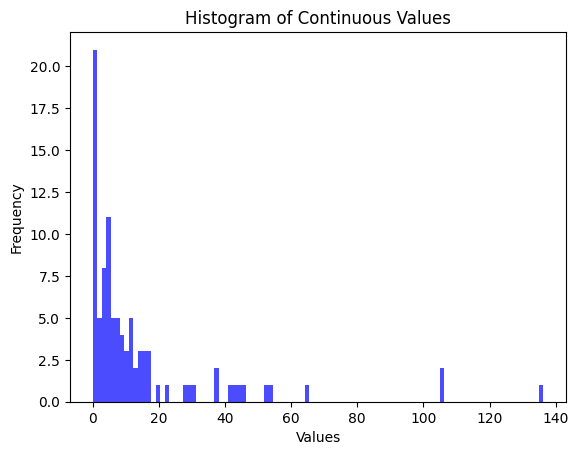

tensor([136.2709], dtype=torch.float64, grad_fn=<UnbindBackward0>)

In [86]:
# check residuals

# Example tensor with continuous values
resid_train = torch.square(model(X_train) - y_train)
resid_test = torch.square(model(X_test) - y_test)

# Plot the histogram
plt.hist(resid_test.detach().numpy(), bins=100, color='blue', alpha=0.7)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Continuous Values')
plt.show()
torch.var(resid_test)

max(resid_test)

### Benchmark

In [34]:
# all train loader
train_loader = torch.utils.data.DataLoader(
    MyDataset(X_train.to(device), y_train.to(device)), 
    batch_size = batch_size, 
    shuffle=False, 
    drop_last = False)

In [83]:
# two layers
bench_model = TwoLayerNet(18, 50, 1)
criterion = nn.MSELoss()
train_loss_list = []
test_loss_list = []
optimizer = optim.SGD(bench_model.parameters(), lr=0.001)

for i in range(2000):
    for x, y in train_loader:
        preds = bench_model(x)
        loss = criterion(preds, y.reshape(-1, 1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = 0
    for x, y in train_loader:
        output = bench_model(x)
        loss = criterion(output, y.reshape(-1, 1))
        train_loss += loss.item()
    train_loss/=len(train_loader)
    train_loss_list.append(train_loss)

    test_loss = 0
    for x, y in test_loader:
        output = bench_model(x)
        loss = criterion(output, y.reshape(-1, 1))
        test_loss += loss.item()
    test_loss/=len(test_loader)
    test_loss_list.append(test_loss)
    
# max resid
torch.max(torch.square(bench_model(X_train) - y_train.reshape(-1, 1)))
# top k resid
torch.topk(torch.square(bench_model(X_train) - y_train.reshape(-1, 1)).reshape(-1), k = 30).values

tensor([18.1326, 16.9158, 13.2685, 11.1682, 10.9249, 10.8018,  9.7288,  9.6721,
         8.9870,  8.6979,  8.3708,  7.2126,  5.7095,  5.3920,  5.3462,  5.0408,
         5.0166,  4.7506,  4.6864,  4.6416,  4.5574,  4.4782,  4.3233,  4.0983,
         3.7779,  3.6808,  3.5915,  3.4926,  3.4802,  3.3064],
       dtype=torch.float64, grad_fn=<TopkBackward0>)

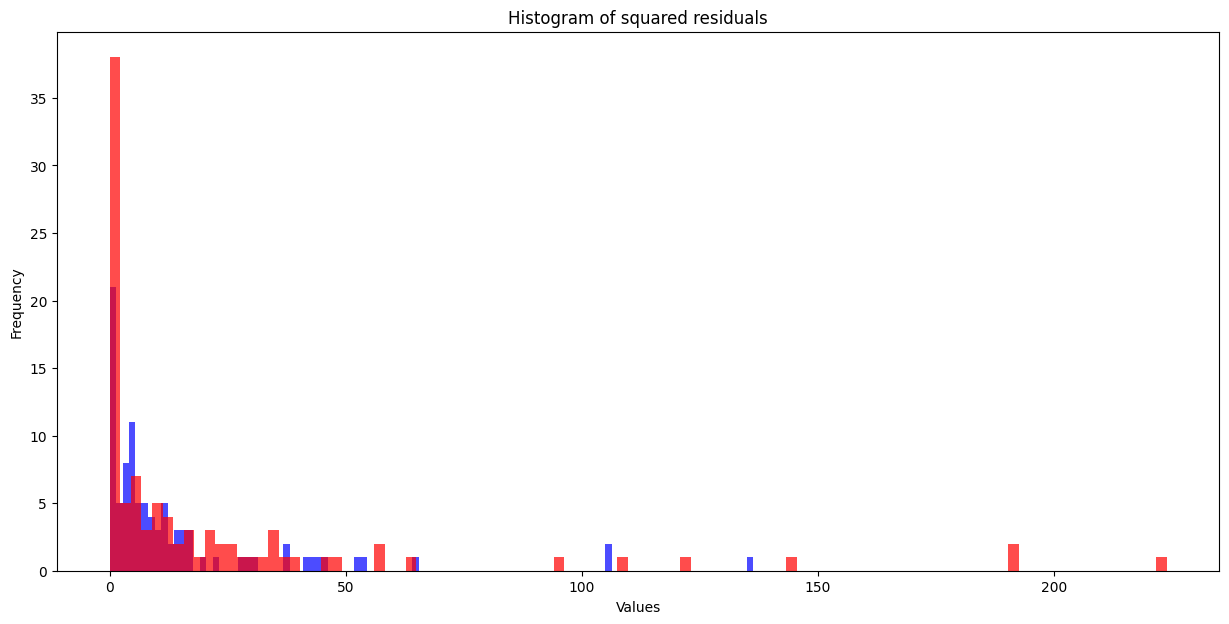

(tensor(532.0978, dtype=torch.float64, grad_fn=<VarBackward0>),
 tensor(1760.7822, dtype=torch.float64, grad_fn=<VarBackward0>),
 tensor([223.8624], dtype=torch.float64, grad_fn=<UnbindBackward0>))

In [87]:
import torch
import matplotlib.pyplot as plt

# Example tensor with continuous values
bench_resid_train = torch.square(bench_model(X_train) - y_train)
bench_resid_test = torch.square(bench_model(X_test) - y_test)
resid_train = torch.square(model(X_train) - y_train)
resid_test = torch.square(model(X_test) - y_test)

# Plot the histogram
plt.figure(figsize=(15, 7))
plt.hist(resid_test.detach().numpy(), bins=100, color='blue', alpha=0.7, label = "Learning algo")
plt.hist(bench_resid_test.detach().numpy(), bins=100, color='red', alpha=0.7, label = "bench")
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of squared residuals')
plt.show()
torch.var(resid_test), torch.var(bench_resid_test), max(bench_resid_test)

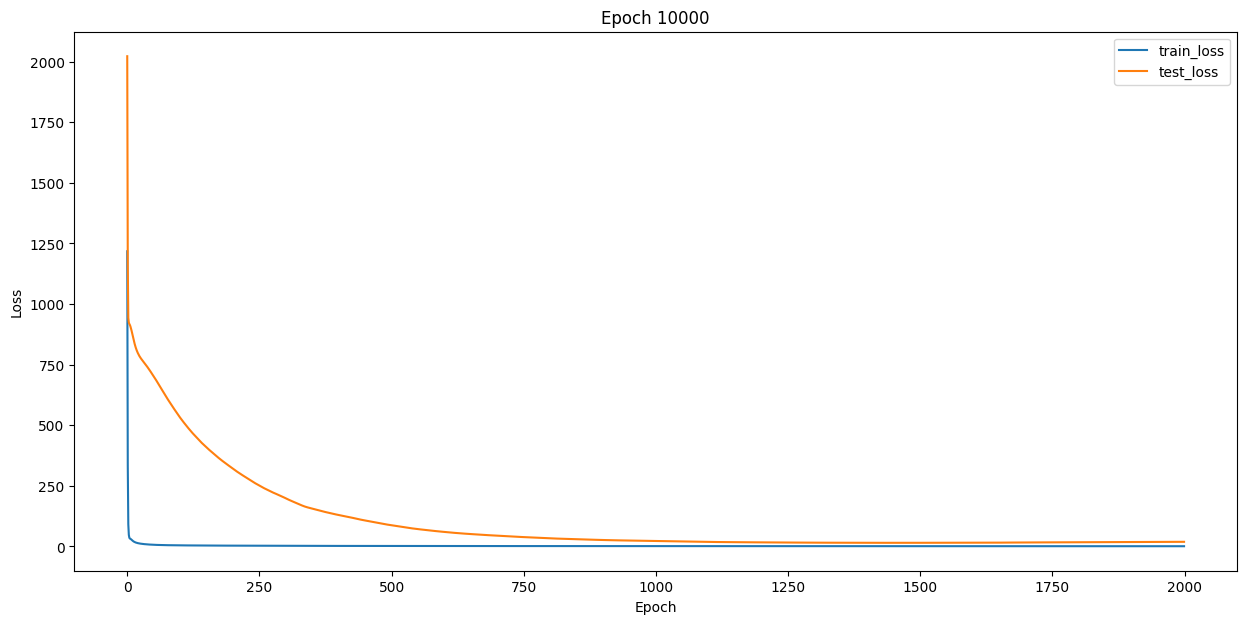

(1.0752453951867, 19.261671371204095)

In [84]:
loss = pd.DataFrame({"train": train_loss_list, "test": test_loss_list})
plt.figure(figsize=(15,7))
plt.plot(loss["train"][00:], label = "train_loss")
plt.plot(loss["test"][00:], label = "test_loss" )
plt.title("Epoch 10000")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
"""
index = loss["test"].idxmin()
loss[loss.index == index]
"""
train_loss_list[-1], test_loss_list[-1]

In [ ]:
# Three layer net
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network class
class ThreeLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ThreeLayerNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size).to(dtype=dtype)
        self.relu = nn.ReLU().to(dtype=dtype)
        self.layer2 = nn.Linear(hidden_size, output_size).to(dtype=dtype)
        self.sigmoid = nn.ReLU().to(dtype=dtype)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        return x

# Create an instance of the ThreeLayerNet class
input_size = 18
hidden_size = 50
output_size = 1
bench_model = ThreeLayerNet(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(bench_model.parameters(), lr=0.001)

# 
train_loss_list = []
test_loss_list = []

for i in range(10000):
    train_loss = 0
    for x, y in train_loader:
        preds = bench_model(x)
        loss = criterion(preds, y.reshape(-1, 1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()


    train_loss = 0
    for x, y in train_loader:
        output = bench_model(x)
        loss = criterion(output, y.reshape(-1, 1))
        train_loss += loss.item()
    train_loss/=len(train_loader)
    train_loss_list.append(train_loss)

    test_loss = 0
    for x, y in test_loader:
        output = bench_model(x)
        loss = criterion(output, y.reshape(-1, 1))
        test_loss += loss.item()
    test_loss/=len(test_loader)    
    test_loss_list.append(test_loss)


loss = pd.DataFrame({"train": train_loss_list, "test": test_loss_list})
plt.figure(figsize=(15,7))
plt.plot(loss["train"][1000:], label = "train_loss")
plt.plot(loss["test"][1000:], label = "test_loss" )
plt.title("Epoch 10000")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
index = loss["test"].idxmin()
loss[loss.index == index]